In [4]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
from scipy.stats import f

In [5]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)

In [99]:
# Função para centralizar os dados
def mean_centering(data):
    numeric_data = pd.DataFrame(data).apply(pd.to_numeric, errors='coerce')  # Convertendo valores não numéricos para NaN
    centered_data = numeric_data.sub(numeric_data.mean())  # Subtraindo a média
    return centered_data.values  # Convertendo de volta para numpy array

# Função para calcular variância explicada acumulada
def explained_variance(pca):
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    return explained_variance

# Teste de incerteza jackknife
def jackknife_variance(pca, X):
    loo = LeaveOneOut()
    explained_variances = []

    for train_index, test_index in loo.split(X):
        X_train = X[train_index]
        pca.fit(X_train)
        explained_variances.append(explained_variance(pca))

    return np.mean(explained_variances, axis=0), np.std(explained_variances, axis=0)

# Determinar o número ótimo de componentes
def determine_optimal_components(X_centered):
    pca = PCA(n_components=15)
    mean_explained_variance, std_explained_variance = jackknife_variance(pca, X_centered)

    min_diff_index = 0
    
    print(mean_explained_variance)

    for i in range(1, len(mean_explained_variance)):
        diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
        if diff <= 0.009:
            min_diff_index = i - 1  # Armazena o índice anterior
            break
    
    optimal_components = min_diff_index + 1  # Adicionar 1 para obter o número correto de componentes

    return optimal_components, mean_explained_variance, std_explained_variance

# Validar o número ótimo de componentes com Leave-One-Out Cross-Validation
def validate_optimal_components(X, n_components):
    loo = LeaveOneOut()
    errors = []

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        reconstruction_error = np.linalg.norm(X_test - pca.inverse_transform(X_test_pca))
        errors.append(reconstruction_error)

    return np.mean(errors)

# Detecção de outliers usando Hotelling's T² e F-residual
def detect_outliers(X, pca, alpha=0.05):
    T2 = np.sum((pca.transform(X) ** 2) / pca.explained_variance_, axis=1)
    Q = np.sum((X - pca.inverse_transform(pca.transform(X))) ** 2, axis=1)
    
    T2_limit = (pca.n_samples_ - 1) * pca.n_components / (pca.n_samples_ - pca.n_components) * \
               f.ppf(1 - alpha, pca.n_components, pca.n_samples_ - pca.n_components)

    outliers = (T2 > T2_limit) | (Q > np.percentile(Q, 100 * (1 - alpha)))

    return outliers, T2, Q, T2_limit

def kennard_stone(data, n_samples):
    # Extrai apenas as colunas relevantes para o cálculo das distâncias
    data_relevant = data.iloc[:, 1:].values
    
    # Calcula as distâncias euclidianas entre todas as amostras
    distances = np.linalg.norm(data_relevant[:, np.newaxis] - data_relevant, axis=-1)
    np.fill_diagonal(distances, np.inf)
    
    selected_samples_ids = []
    selected_samples = [np.argmax(distances.sum(axis=0))]  # Índice da primeira amostra selecionada
    selected_samples_ids.append(data.iloc[selected_samples[0], 0])  # Adiciona o identificador da primeira amostra

    for _ in range(1, n_samples):
        dist_to_selected = distances[:, selected_samples].min(axis=1)
        next_sample_index = np.argmax(dist_to_selected)
        
        # Verifica se next_sample_index já foi selecionado
        while next_sample_index in selected_samples:
            dist_to_selected[next_sample_index] = np.inf  # Ignora a amostra já selecionada
            next_sample_index = np.argmin(dist_to_selected) # Seleciona a próxima amostra não selecionada
        
        selected_samples.append(next_sample_index)
        selected_samples_ids.append(data.iloc[next_sample_index, 0])  # Adiciona o identificador da próxima amostra

    # Seleciona os dados completos das amostras selecionadas, incluindo a primeira coluna
    selected_data = data.iloc[selected_samples].copy()
    selected_data_df = pd.DataFrame(selected_data)

    return selected_data_df

# Função para salvar os dados de calibração e validação
def save_calibration_validation_data(calibration_data, validation_data, calibration_file='calibration_data.xlsx', validation_file='validation_data.xlsx'):
    calibration_data.to_excel(calibration_file, index=False)
    validation_data.to_excel(validation_file, index=False)
    print(f"Calibration data saved to '{calibration_file}'")
    print(f"Validation data saved to '{validation_file}'")

# Função principal
def main(data):
    # Convertendo os dados para um DataFrame com o mesmo índice de df_raw
    df_data = pd.DataFrame(data, index=df_raw.index)
    
    # Adicionando a primeira coluna de df_raw ao df_data
    df_data.insert(0, 'Amostra', df_raw[df_raw.columns[0]])
    
    # Aplicando a função mean_centering às colunas numéricas, excluindo a primeira coluna
    numeric_columns = df_data.columns[1:]  # Exclui a coluna 'Amostra'
    df_data[numeric_columns] = mean_centering(df_data[numeric_columns].values)

    # Verificação de NaNs apenas nas colunas numéricas
    if df_data.isna().any().any():
        print("Os dados contêm NaNs. Por favor, limpe os dados antes de prosseguir.")
        return
    
    # Determinação do número ótimo de componentes
    optimal_components, mean_explained_variance, std_explained_variance = determine_optimal_components(df_data.iloc[:, 1:].values)
    print(f"Optimal number of components: {optimal_components}")
    
    # Validação do número ótimo de componentes
    cross_val_error = validate_optimal_components(df_data.iloc[:, 1:].values, optimal_components)
    
    # Aplicação do PCA com o número ótimo de componentes
    pca = PCA(n_components=optimal_components)
    pca.fit(df_data.iloc[:, 1:].values)

    # Seleção de amostras usando o método Kennard-Stone
    total_samples = df_data.shape[0]
    n_samples_calibration = int(0.7 * total_samples)

    selected_data_indices = kennard_stone(df_data, n_samples_calibration)
    selected_data_indices = df_data.iloc[selected_data_indices.index].index.tolist()
    selected_data = df_data.loc[selected_data_indices]

    # Cálculo do número de amostras de validação
    n_samples_validation = total_samples - n_samples_calibration
    
    # Criando conjuntos de dados de calibração e validação
    calibration_data = selected_data.sort_values(by='Amostra')
    print("Calibration data:", calibration_data.shape)
    validation_data = df_data[~df_data.index.isin(selected_data.index)]
    validation_data = validation_data.sort_values(by='Amostra')
    print("Validation data:", validation_data.shape)
    
    # Salvando os conjuntos de dados de calibração e validação
    save_calibration_validation_data(calibration_data, validation_data)
    
    # Detecção de outliers
    outliers, T2, Q, T2_limit = detect_outliers(calibration_data.iloc[:, 1:].values, pca)
    
    # Cálculo da variância explicada acumulada para calibração
    pca_calibration = PCA(n_components=optimal_components)
    pca_calibration.fit(mean_centering(calibration_data.iloc[:, 1:].values))
    explained_variances_calibration = explained_variance(pca_calibration)

    # Visualização dos resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(explained_variances_calibration, label='Explained Variance Ratio (Calibration)')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components (Calibration)')
    plt.axvline(optimal_components - 1, color='r', linestyle='--', label=f'Optimal Components: {optimal_components}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(T2, Q, c=outliers, cmap='coolwarm', edgecolor='k')
    plt.axhline(np.percentile(Q, 100 * (1 - 0.027)), color='r', linestyle='--', label=f'Q Limit: {np.percentile(Q, 100 * (1 - 0.02)):.2f}')
    plt.axvline(T2_limit, color='g', linestyle='--', label=f'T2 Limit: {T2_limit:.2f}')
    plt.xlabel("Hotelling's T²")
    plt.ylabel('F-residual')
    plt.title('Outlier Detection')
    plt.legend(title='Limits')

    plt.tight_layout()
    plt.show()

    print(f'Optimal number of components: {optimal_components}')
    print(f'Cross-Validation Error: {cross_val_error}')
    print(f'Outliers detected: {np.sum(outliers)}')
    
    # Verificações de validação
    assert len(calibration_data) == n_samples_calibration, f"Calibration data does not have {n_samples_calibration} samples."
    if len(validation_data) != n_samples_validation:
        raise ValueError(f"Validation data does not have {n_samples_validation} samples. Incorrect selection.")
    
    # Divisão dos componentes entre calibração e validação
    n_calib_components = int(0.7 * optimal_components)
    n_valid_components = optimal_components - n_calib_components
    
    
    # Garantir que o número de componentes para validação seja pelo menos 1
    if n_valid_components < 1:
        n_valid_components = 1
        n_calib_components = optimal_components - n_valid_components
    
    # Aplicar PCA aos conjuntos de dados de calibração e validação
    pca_calibration = PCA(n_components=n_calib_components)
    pca_calibration.fit(calibration_data.iloc[:, 1:].values)
    
    pca_validation = PCA(n_components=n_valid_components)
    pca_validation.fit(validation_data.iloc[:, 1:].values)

[0.79360913 0.89412885 0.94697142 0.97166537 0.98796145 0.99201269
 0.9941883  0.99583757 0.99700547 0.99750741 0.99785709 0.9981647
 0.99839712 0.99858418 0.9987251 ]
Optimal number of components: 5
Calibration data: (175, 2151)
Validation data: (75, 2151)
Calibration data saved to 'calibration_data.xlsx'
Validation data saved to 'validation_data.xlsx'


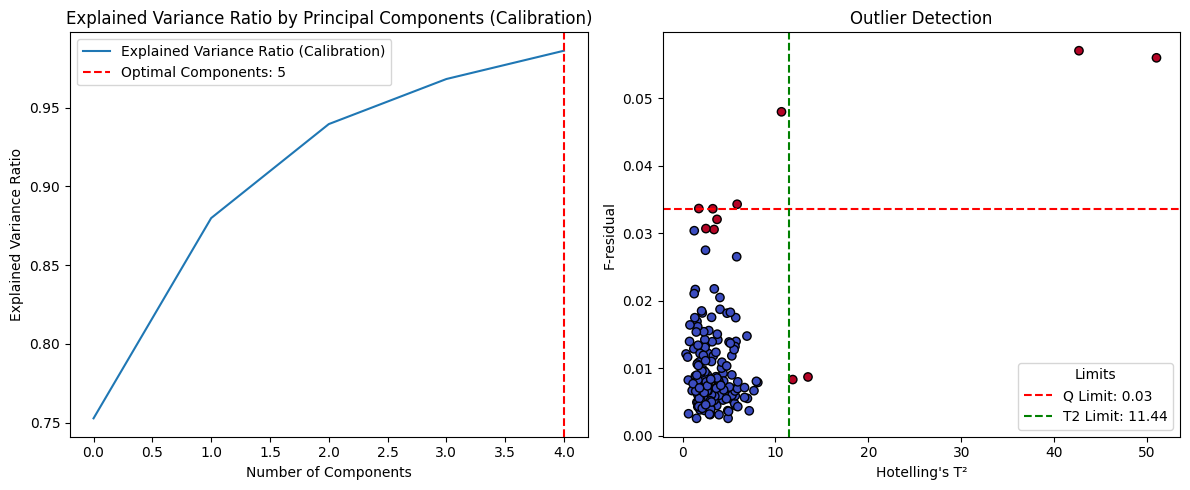

Optimal number of components: 5
Cross-Validation Error: 0.11097197952174379
Outliers detected: 11


In [95]:
# Carregue seus dados aqui
X_raw = df_raw.iloc[:, 7:2157].values

main(X_raw)

[0.63415391 0.81687494 0.92296768 0.94849832 0.96183105 0.97175589
 0.97969418 0.98311099 0.98536996 0.98744399 0.98895769 0.99013848
 0.99124848 0.99220169 0.99290356]
Optimal number of components: 6
Calibration data: (175, 2152)
Validation data: (75, 2152)
Calibration data saved to 'calibration_data.xlsx'
Validation data saved to 'validation_data.xlsx'


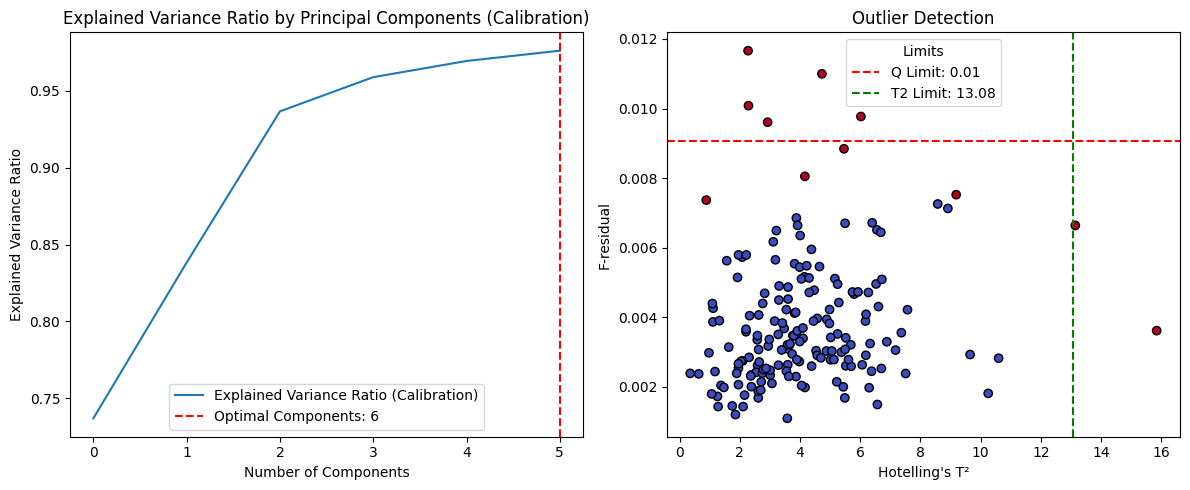

Optimal number of components: 6
Cross-Validation Error: 0.07068600700955122
Outliers detected: 11


In [100]:
# Carregue seus dados aqui
X_msc = df_msc

main(X_msc)

[0.62761992 0.81173756 0.91893582 0.94480759 0.95828144 0.96835127
 0.97637824 0.98052037 0.9836669  0.98590496 0.98747463 0.98900196
 0.99012594 0.99123933 0.99220022]
Optimal number of components: 6
Calibration data: (175, 2152)
Validation data: (75, 2152)
Calibration data saved to 'calibration_data.xlsx'
Validation data saved to 'validation_data.xlsx'


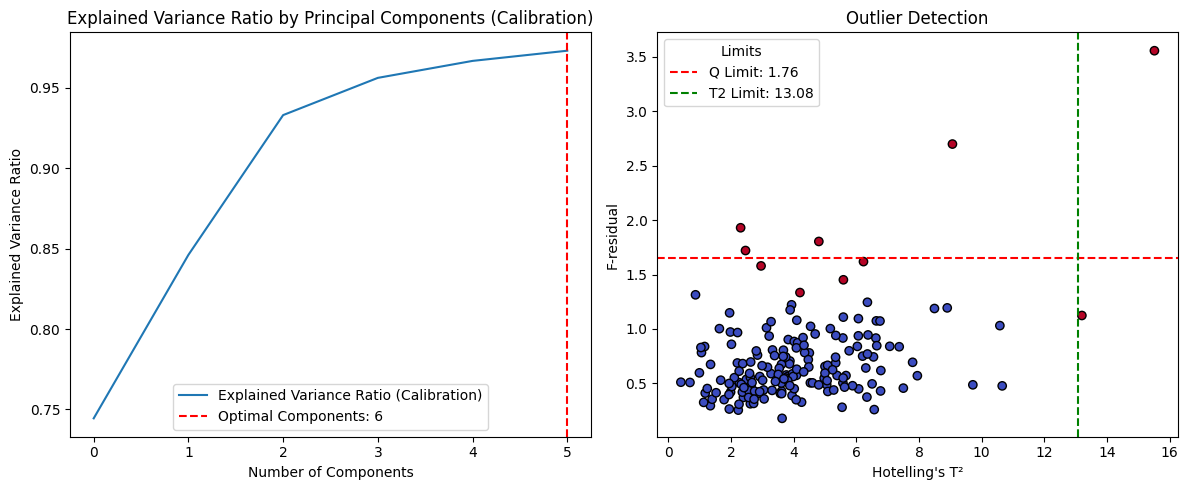

Optimal number of components: 6
Cross-Validation Error: 0.9528668191519305
Outliers detected: 10


In [101]:
# Carregue seus dados aqui
X_snv = df_snv

main(X_snv)

[0.54558264 0.84010383 0.92509    0.95695248 0.96976335 0.98070244
 0.98565135 0.98842508 0.99076767 0.99296294 0.99445082 0.99542722
 0.99617135 0.99684876 0.99735259]
Optimal number of components: 6
Calibration data: (175, 2152)
Validation data: (75, 2152)
Calibration data saved to 'calibration_data.xlsx'
Validation data saved to 'validation_data.xlsx'


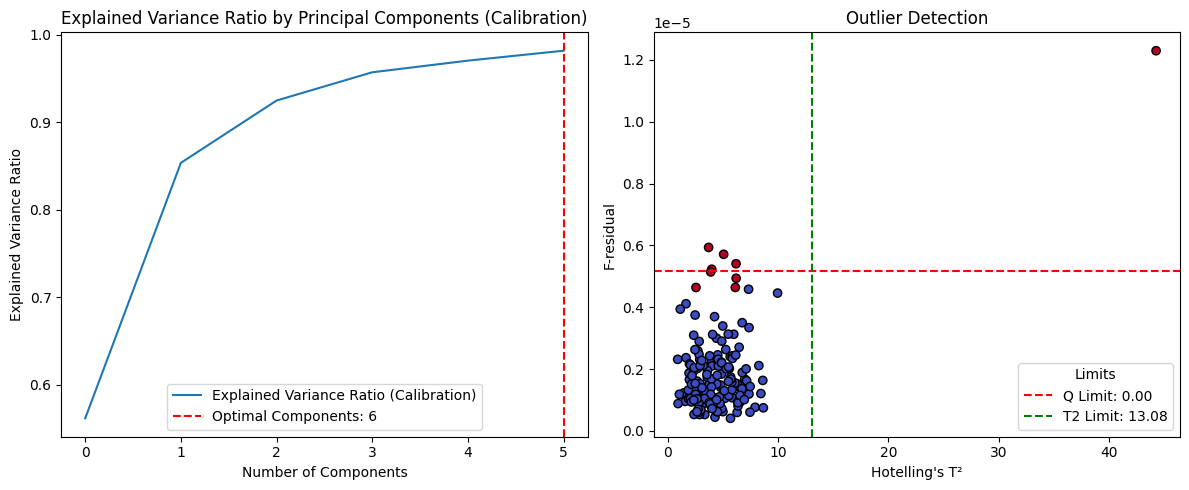

Optimal number of components: 6
Cross-Validation Error: 0.0015266562113790845
Outliers detected: 9


In [102]:
X_sg = df_sg
main(X_sg)